In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
 

In [2]:
# Load flower dataset
dataset, info = tfds.load(
    "tf_flowers",
    as_supervised=True,
    with_info=True
)

train_ds = dataset['train']

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/tf_flowers/incomplete.3LUTY8_3.0.1/tf_flowers-train.tfrecord*...:   0%|   …

Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


In [5]:
class_names = info.features['label'].names
print(class_names)

['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']


In [4]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
NUM_CLASSES = 5


In [6]:
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
])


In [7]:
def preprocess(image, label):
    image = tf.image.resize(image, IMG_SIZE)
    image = tf.cast(image, tf.float32) / 255.0
    return image, label


In [8]:
train_ds = train_ds.map(preprocess)
train_ds = train_ds.shuffle(1000).batch(BATCH_SIZE)


In [9]:
class_names = info.features['label'].names
print(class_names)

['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']


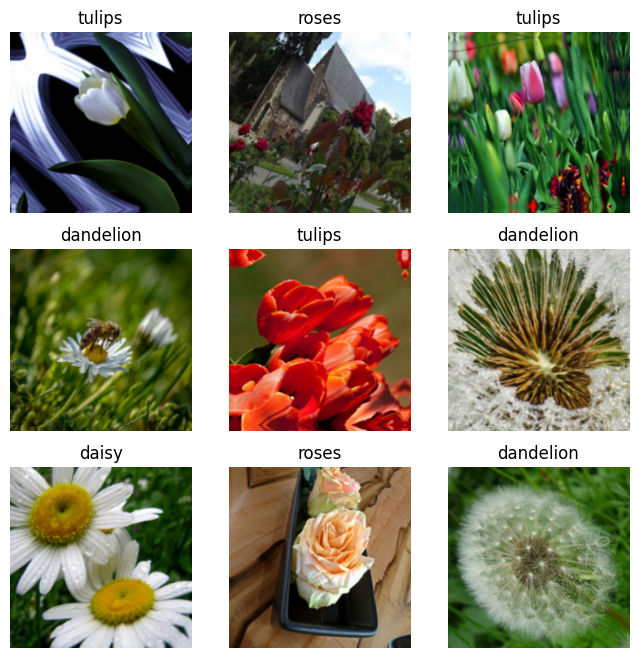

In [10]:
plt.figure(figsize=(8,8))

for images, labels in train_ds.take(1):
    augmented = data_augmentation(images)

    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(augmented[i])
        plt.title(class_names[labels[i]])
        plt.axis("off")

plt.show()


In [11]:
base_model = keras.applications.InceptionV3(
    weights="imagenet",
    include_top=False,
    input_shape=(224,224,3)
)

base_model.trainable = False   # Transfer Learning

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [12]:
inputs = keras.Input(shape=(224,224,3))

x = data_augmentation(inputs)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation="relu")(x)
outputs = layers.Dense(NUM_CLASSES, activation="softmax")(x)

model = keras.Model(inputs, outputs)

In [13]:
lr_scheduler = keras.callbacks.ReduceLROnPlateau(
    monitor="loss",
    factor=0.3,
    patience=2
)

In [14]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)


In [ ]:
history = model.fit(
    train_ds,
    epochs=10,
    callbacks=[lr_scheduler]
)


Epoch 1/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 502s 4s/step - accuracy: 0.6573 - loss: 0.9499 - learning_rate: 0.0010
Epoch 2/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 481s 4s/step - accuracy: 0.8304 - loss: 0.4600 - learning_rate: 0.0010
Epoch 3/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 503s 4s/step - accuracy: 0.8347 - loss: 0.4497 - learning_rate: 0.0010
Epoch 4/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 500s 4s/step - accuracy: 0.8688 - loss: 0.3712 - learning_rate: 0.0010
Epoch 5/10
 81/115 ━━━━━━━━━━━━━━━━━━━━ 2:27 4s/step - accuracy: 0.8827 - loss: 0.3256

In [ ]:
def predict_single_image(image_path):
    img = keras.utils.load_img(image_path, target_size=IMG_SIZE)
    img_array = keras.utils.img_to_array(img)
    img_array = img_array / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    predictions = model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions)]

    plt.imshow(img)
    plt.title(f"Prediction: {predicted_class}")
    plt.axis("off")
    plt.show()

In [ ]:
predict_single_image("/content/download (1).jpg")